# Main Notebook for Comparative Analysis of XAI Methods

## 01 - Data Analysis (Kaggle Brain Tumor MRI)

In [1]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image
from config import KAGGLE_DATASET_PATH

In [2]:
base_dir = KAGGLE_DATASET_PATH
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

In [3]:
# Analysis of class distribution in train and test data
class_counts = {"train": {}, "test": {}}
for split, directory in [("train", train_dir), ("test", test_dir)]:
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[split][class_name] = num_images

print("Class distribution in training data:", class_counts["train"])
print("Class distribution in testing data:", class_counts["test"])

Class distribution in training data: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Class distribution in testing data: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


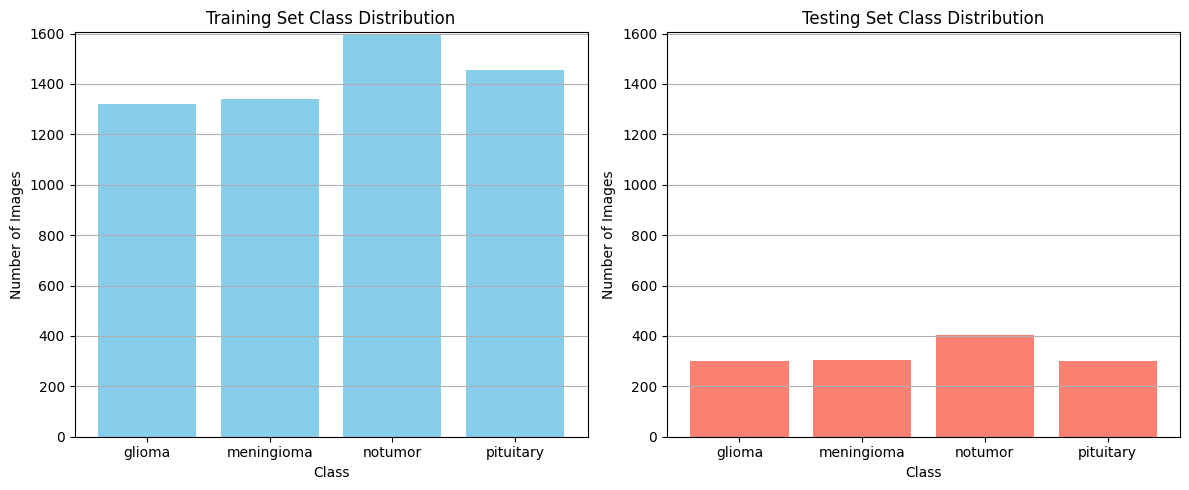

In [4]:
# Plotting the class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(class_counts["train"].keys(), class_counts["train"].values(), color='skyblue')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y')
axes[1].bar(class_counts["test"].keys(), class_counts["test"].values(), color='salmon')
axes[1].set_title('Testing Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y')
#Make the y-axis limits the same for better comparison
y_max = max(max(class_counts["train"].values()), max(class_counts["test"].values()))
axes[0].set_ylim(0, y_max + 10)
axes[1].set_ylim(0, y_max + 10)
plt.tight_layout()
plt.show()

In [5]:
#Analysing binary class distribution for tumor vs no_tumor classification
binary_class_counts = {"train": {"notumor": 0, "tumor": 0}, "test": {"notumor": 0, "tumor": 0}}
for split, directory in [("train", train_dir), ("test", test_dir)]:
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            if class_name == "notumor":
                binary_class_counts[split]["notumor"] += num_images
            else:
                binary_class_counts[split]["tumor"] += num_images
print("Binary class distribution in training data:", binary_class_counts["train"])
print("Binary class distribution in testing data:", binary_class_counts["test"])

Binary class distribution in training data: {'notumor': 1595, 'tumor': 4117}
Binary class distribution in testing data: {'notumor': 405, 'tumor': 906}


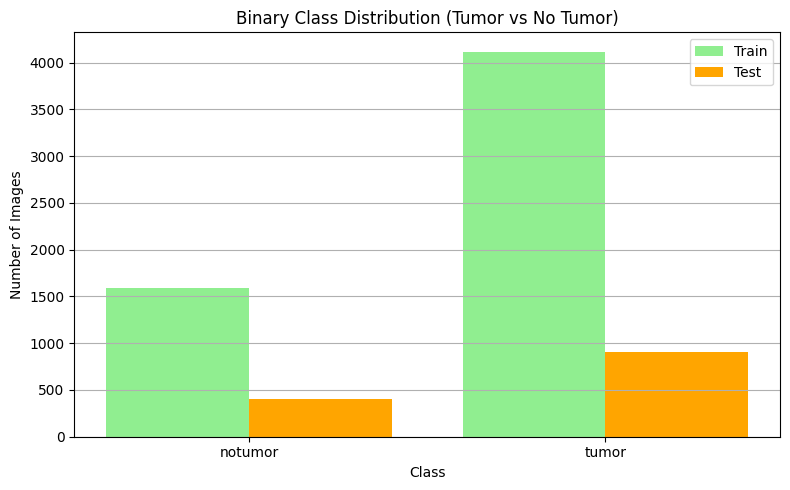

In [6]:
# Plotting the binary class distribution in a grouped bar chart
labels = ['notumor', 'tumor']
train_counts = [binary_class_counts["train"]["notumor"], binary_class_counts["train"]["tumor"]]
test_counts = [binary_class_counts["test"]["notumor"], binary_class_counts["test"]["tumor"]]
x = range(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([p - 0.2 for p in x], train_counts, width=0.4, label='Train', color='lightgreen')
ax.bar([p + 0.2 for p in x], test_counts, width=0.4, label='Test', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Binary Class Distribution (Tumor vs No Tumor)')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
# Summary statistics
total_train_images = sum(class_counts["train"].values())
total_test_images = sum(class_counts["test"].values())
print(f"Total training images: {total_train_images}")
print(f"Total testing images: {total_test_images}")
num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

Total training images: 5712
Total testing images: 1311
Number of classes: 4


Sample images from training set:


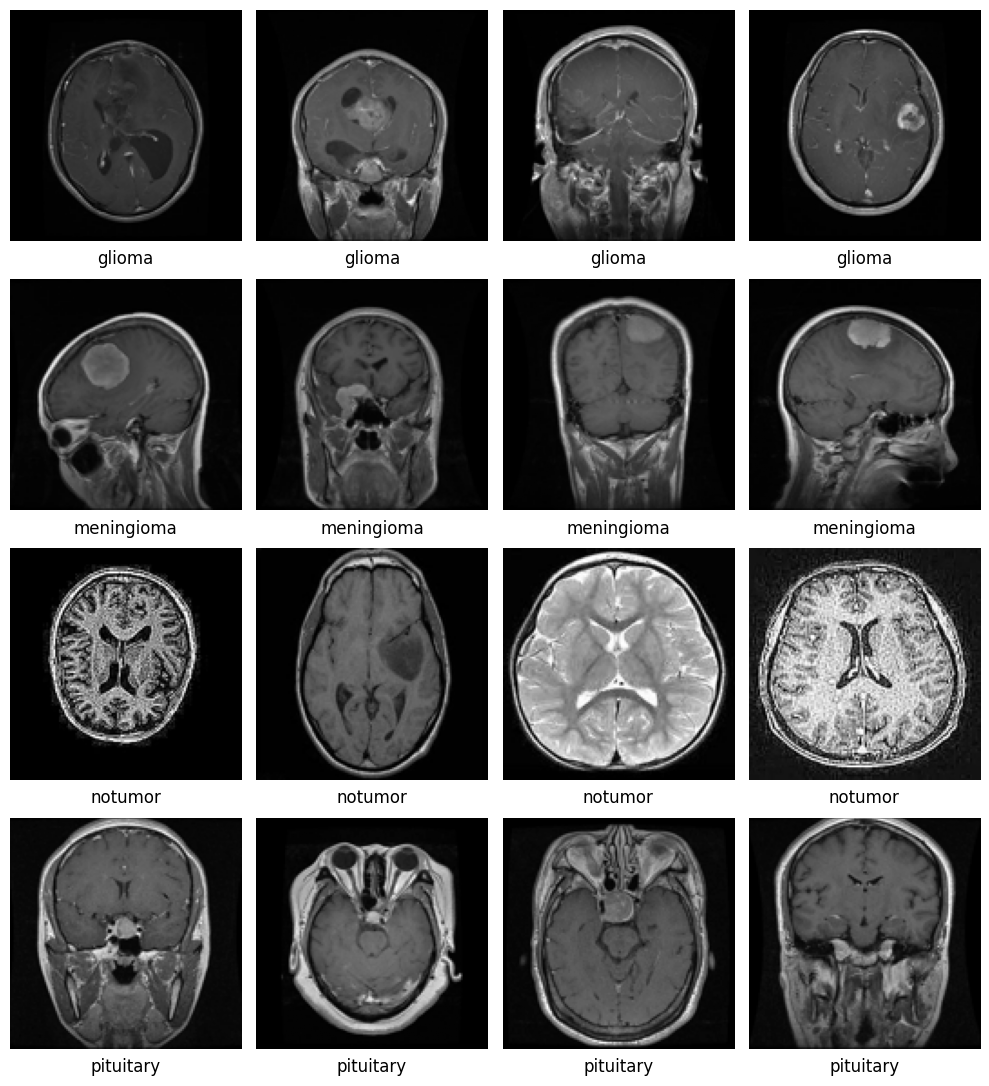

In [8]:
def sample_images(dir, sample_per_class=4, figsize=(10,11), resize_to=(128, 128)):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    fig, axes = plt.subplots(len(classes), sample_per_class, figsize=figsize)
    if len(classes) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one class
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dir, class_name)
        images = os.listdir(class_path)
        chosen_images = random.sample(images, min(sample_per_class, len(images)))
        for j, img_name in enumerate(chosen_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            if resize_to:
                img = img.resize(resize_to)
            axes[i][j].imshow(img, cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].text(0.5, -0.1, class_name, size=12, ha="center", transform=axes[i][j].transAxes)
        for j in range(len(chosen_images), sample_per_class):
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()
print("Sample images from training set:")
sample_images(train_dir)

## 02 - Model Training

### Imports

In [1]:
import os, csv, h5py
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm
from config import KAGGLE_DATASET_PATH, BRATS_DATASET_PATH, MODEL_PARAMS

# Check for GPU availability
print("CUDA Available:", torch.cuda.is_available())

c:\Users\ahmet\.conda\envs\XAI_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA Available: True


### Setting up Kaggle Brain MRI Dataloaders

In [2]:
class BinaryMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.labels = []
        self.classes = ['notumor', 'tumor']
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_path):
                continue
            for fn in os.listdir(cls_path):
                if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(cls_path, fn))
                    self.labels.append(0 if cls == 'notumor' else 1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {path}: {e}, providing a black image instead.")
            img = Image.new('RGB', (224, 224), (0,0,0))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [3]:
# transforms
image_size = MODEL_PARAMS.get('image_size', 224)

# Training: mild augmentations for brain MRI
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),         
    transforms.RandomVerticalFlip(p=0.2),           
    transforms.RandomAffine(
        degrees=15,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=0.0
    ),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),   
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.15),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229]),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229]),
])

In [4]:
# directories
base_dir = KAGGLE_DATASET_PATH
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# datasets
train_dataset = BinaryMRIDataset(train_dir, transform=train_transform)
val_dataset = BinaryMRIDataset(test_dir, transform=val_transform)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))

Classes: ['notumor', 'tumor']
Train samples: 5712 Val samples: 1311


In [5]:
# dataloaders
BATCH_SIZE = MODEL_PARAMS.get('batch_size', 32)
NUM_WORKERS = MODEL_PARAMS.get('num_workers', 4)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

### Setting Up BraTS Dataloader For External Validation

In [6]:
brats_dir = Path(BRATS_DATASET_PATH) / "content" / "data"
csv_path = "BraTS/BraTS_selected_slices.csv"

In [7]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, sample_csv, modality_index=2):
        self.root_dir = root_dir
        self.sample_csv = sample_csv
        self.modality_index = modality_index # Default to T1-contrast modality (index 2) to be consistent with Kaggle MRI Dataset
        self.samples = []

        with open(sample_csv, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                rel_path = row[0]
                full_path = os.path.join(root_dir, rel_path)
                if os.path.exists(full_path) and full_path.endswith(".h5"):
                    self.samples.append(full_path)

        self.normalize = transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
        self.resize = transforms.Resize((MODEL_PARAMS.get('image_size', 224), MODEL_PARAMS.get('image_size', 224)), antialias=True)
        
    @staticmethod
    def _minmax01(img_np):
        # Function to normalize image intensities to [0,1]
        lo, hi = np.min(img_np), np.max(img_np)
        img = np.clip(img_np, lo, hi)
        if hi > lo:
            img = (img - lo) / (hi - lo)
        else:
            print("Error: hi <= lo in minmax01 normalization for BraTS Dataset, returning zero image.")
            img = np.zeros_like(img_np, dtype=np.float32)
        return img.astype(np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path = self.samples[idx]
        with h5py.File(rel_path, 'r') as f:
            slice = f['image'][:][:, :, self.modality_index].astype(np.float32)  # (H, W)

        # Intensity normalize to [0,1]
        slice = self._minmax01(slice)
        # To torch tensor (C,H,W) and replicate to 3 channels for ImageNet backbone
        slice = torch.from_numpy(slice)[None, ...]               # (1,H,W)
        img = slice.repeat(3, 1, 1).contiguous()               # (3,H,W)
        # Apply same resizing + ImageNet normalization as Kaggle val
        img = self.resize(img)
        img = self.normalize(img)
        return img
            

Sample image shape from BraTS Dataset: torch.Size([3, 224, 224])
Number of samples in BraTS Dataset: 326


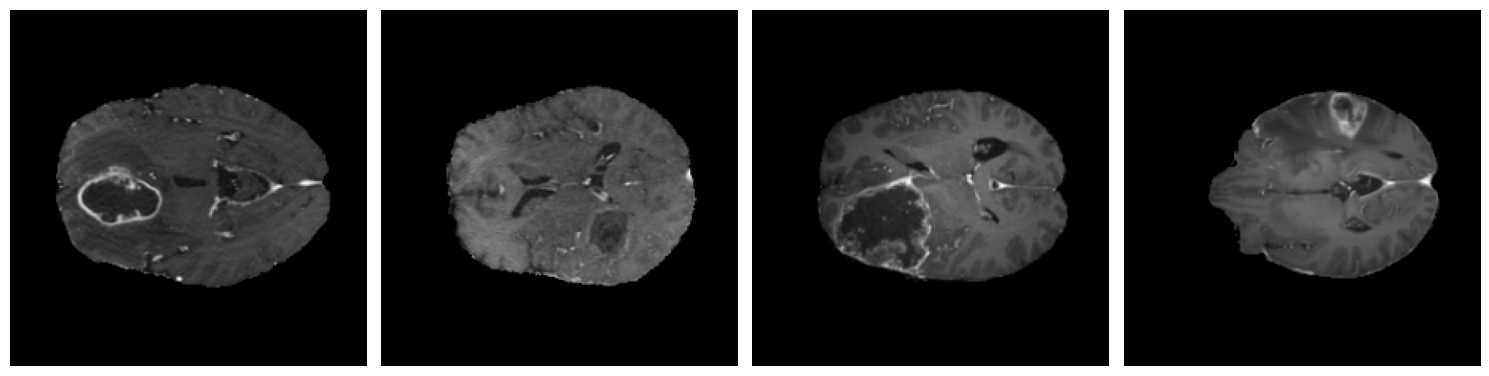

In [8]:
smaple_brats_ds = BraTSDataset(brats_dir, csv_path)

brats_len = len(smaple_brats_ds)
one_sample = smaple_brats_ds[0]
print("Sample image shape from BraTS Dataset:", one_sample.size())
print("Number of samples in BraTS Dataset:", brats_len)

#Plot some sample from BraTS dataset
num_samples = 4
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    sample = smaple_brats_ds[np.random.randint(0, brats_len)]
    #Plot just one channel since all 3 are identical
    img_np = sample[0].numpy()
    axes[i].imshow(img_np, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# BraTS dataloader
brats_ds = BraTSDataset(brats_dir, csv_path)
brats_loader = DataLoader(brats_ds, batch_size=MODEL_PARAMS.get('batch_size', 16), shuffle=False)

### Training the Foundation Model

In [10]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = MODEL_PARAMS.get('timm_model_name', 'resnet50')
model = timm.create_model(model_name, pretrained=True, num_classes=2)
model = model.to(device)
print("Model created:", model_name)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=MODEL_PARAMS.get('learning_rate', 1e-4), weight_decay=MODEL_PARAMS.get('weight_decay', 1e-5))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

c:\Users\ahmet\.conda\envs\XAI_env\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ahmet\.cache\huggingface\hub\models--timm--densenet121.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model created: densenet121


In [11]:
# training loop
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.*correct/total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc='Val', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.*correct/total

In [12]:
# BraTS evaluation function
def evaluate_brats_dataset(model, brats_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    label = 1 # BraTS samples all have tumors
    with torch.no_grad():
        pbar = tqdm(brats_loader, desc='BraTS Eval', leave=False)
        for inputs in pbar:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            loss = criterion(outputs, torch.full((inputs.size(0),), label, dtype=torch.long, device=device))
            running_loss += loss.item() * inputs.size(0)
            correct += (preds == label).sum().item()
            total += inputs.size(0)
            pbar.set_postfix(running_loss = running_loss/total, acc = 100.*correct/total)
    return running_loss / total, 100.*correct/total

In [13]:
# run Kaggle training with BraTS evaluation
epochs = MODEL_PARAMS.get('num_epochs', 25)
best_val_acc = 0.0
save_best = MODEL_PARAMS.get('save_best', False)
model_name = MODEL_PARAMS.get('save_name', 'best_model.pth')
save_path = Path(MODEL_PARAMS.get('save_path', 'runs')) / model_name
os.makedirs(save_path.parent, exist_ok=True)


for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    brats_loss, brats_acc = evaluate_brats_dataset(model, brats_loader, criterion, device)
    scheduler.step()
    
    print(f"  Train loss: {train_loss:.4f}  acc: {train_acc:.2f}%")
    print(f"  Val   loss: {val_loss:.4f}  acc: {val_acc:.2f}%")
    print(f"  BraTS loss: {brats_loss:.4f}  acc: {brats_acc:.2f}%")

    if save_best and val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'classes': train_dataset.classes
        }, save_path)
        print(f"  Saved best model to {save_path} (val_acc={val_acc:.2f}%)")

print(f"Training finished. Best Val acc: {best_val_acc:.2f}%")

Epoch 1/15


  Train loss: 0.5014  acc: 82.46%
  Val   loss: 0.4727  acc: 79.41%
  BraTS loss: 0.2386  acc: 99.69%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=79.41%)
Epoch 2/15


  Train loss: 0.2541  acc: 91.09%
  Val   loss: 0.3048  acc: 87.03%
  BraTS loss: 0.1259  acc: 100.00%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=87.03%)
Epoch 3/15


  Train loss: 0.2106  acc: 92.73%
  Val   loss: 0.5928  acc: 80.47%
  BraTS loss: 0.2510  acc: 93.56%
Epoch 4/15


  Train loss: 0.1830  acc: 93.36%
  Val   loss: 0.2214  acc: 92.75%
  BraTS loss: 0.1794  acc: 100.00%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=92.75%)
Epoch 5/15


  Train loss: 0.1638  acc: 94.57%
  Val   loss: 0.1881  acc: 92.52%
  BraTS loss: 0.0777  acc: 100.00%
Epoch 6/15


  Train loss: 0.1297  acc: 95.52%
  Val   loss: 0.2439  acc: 92.30%
  BraTS loss: 0.0685  acc: 100.00%
Epoch 7/15


  Train loss: 0.1277  acc: 95.33%
  Val   loss: 0.5129  acc: 84.36%
  BraTS loss: 0.3367  acc: 92.94%
Epoch 8/15


  Train loss: 0.1104  acc: 96.20%
  Val   loss: 0.1867  acc: 92.45%
  BraTS loss: 0.1386  acc: 100.00%
Epoch 9/15


  Train loss: 0.1093  acc: 96.31%
  Val   loss: 0.5106  acc: 84.82%
  BraTS loss: 0.0125  acc: 100.00%
Epoch 10/15


  Train loss: 0.1125  acc: 96.25%
  Val   loss: 0.4761  acc: 83.37%
  BraTS loss: 0.3606  acc: 91.41%
Epoch 11/15


  Train loss: 0.0845  acc: 97.16%
  Val   loss: 0.3549  acc: 86.65%
  BraTS loss: 0.2735  acc: 92.02%
Epoch 12/15


  Train loss: 0.0787  acc: 97.46%
  Val   loss: 0.1499  acc: 94.20%
  BraTS loss: 0.0333  acc: 100.00%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=94.20%)
Epoch 13/15


  Train loss: 0.0804  acc: 97.37%
  Val   loss: 0.1272  acc: 95.35%
  BraTS loss: 0.0290  acc: 100.00%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=95.35%)
Epoch 14/15


  Train loss: 0.0709  acc: 97.67%
  Val   loss: 0.9829  acc: 74.29%
  BraTS loss: 0.7247  acc: 71.78%
Epoch 15/15


  Train loss: 0.0876  acc: 97.08%
  Val   loss: 0.1095  acc: 95.42%
  BraTS loss: 0.0448  acc: 100.00%
  Saved best model to runs\experiment_1\densenet121_1.pth (val_acc=95.42%)
Training finished. Best Val acc: 95.42%


In [ ]:
# final evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_path = Path(MODEL_PARAMS.get('save_path', 'runs')) / MODEL_PARAMS.get('save_name', 'best_model.pth')
model_metadata = torch.load(load_path)

model = timm.create_model(MODEL_PARAMS.get("timm_model_name", "resnet50"), pretrained=False, num_classes=2)
model.load_state_dict(model_metadata['model_state_dict'])
model = model.to(device)
criterion = nn.CrossEntropyLoss()

val_loss, val_acc = validate(model, val_loader, criterion, device)
brats_loss, brats_acc = evaluate_brats_dataset(model, brats_loader, criterion, device)
print(f"Final Validation loss: {val_loss:.4f}  acc: {val_acc:.2f}%")
print(f"Final BraTS loss: {brats_loss:.4f}  acc: {brats_acc:.2f}%")

C:\Users\Victus\AppData\Local\Temp\ipykernel_21296\622416731.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_metadata = torch.load(load_path)
                     

Final Validation loss: 0.0058  acc: 99.77%
Final BraTS loss: 0.0396  acc: 99.69%


## 03 - Grad-CAM Visualization

In [21]:
import os, csv, h5py
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from config import BRATS_DATASET_PATH, KAGGLE_DATASET_PATH, MODEL_PARAMS
from pathlib import Path
import torch
from torchvision import transforms
import timm

model_path = Path(MODEL_PARAMS.get('save_path', 'runs')) / MODEL_PARAMS.get('save_name', 'best_model.pth')
if not model_path.exists():
    print(f"Model file {model_path} does not exist. Please be sure to train the model first.")

# Set Random Seed for Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [22]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_metadata = torch.load(model_path)
model_name = MODEL_PARAMS.get("timm_model_name", "resnet50")
model = timm.create_model(model_name, pretrained=False, num_classes=2)
model.load_state_dict(model_metadata['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model {model_name} loaded from:", model_path)

Model densenet121 loaded from: runs\experiment_1\densenet121_1.pth


In [23]:
# Grad-CAM setup for the last convolutional layer of ResNet50 as default
if model_name.startswith("resnet"):
    target_layers = [model.layer4[-1]]
elif model_name.startswith("densenet"):
    target_layers = [model.features[-1]]
else:
    print(f"Model target layer not handled for {model_name} for Grad-CAM. Handle with caution.")

cam = GradCAM(
    model=model,
    target_layers=target_layers
)
print("Grad-CAM initialized.")

Grad-CAM initialized.


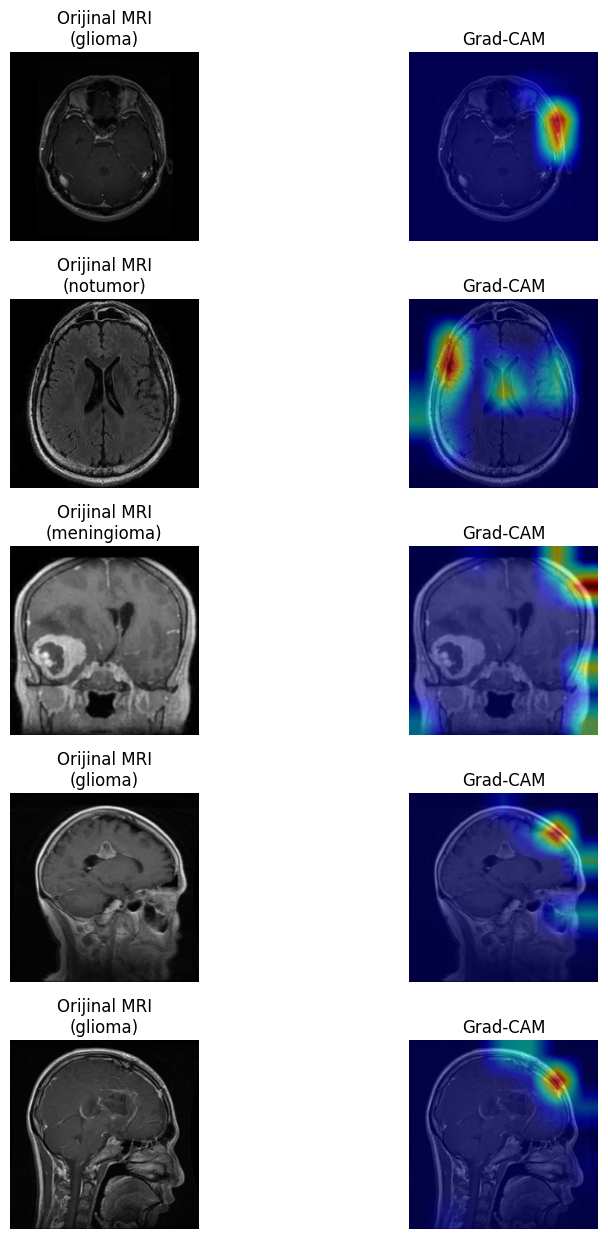

In [24]:
# Visualize Grad-CAM on random samples from Kaggle test set
test_dir = Path(KAGGLE_DATASET_PATH) / "Testing"
NUM_SAMPLES = 5

image_size = MODEL_PARAMS.get('image_size', 224)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229]),
])

def load_kaggle_image_for_cam(img_path):
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = test_transform(pil_img).unsqueeze(0).to(device)
    rgb_img = pil_img.resize((image_size, image_size))
    rgb_img = np.array(rgb_img).astype(np.float32) / 255.0
    return rgb_img, input_tensor

fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(10, NUM_SAMPLES * 2.5))

for i in range(NUM_SAMPLES):
    random_class = random.choice(os.listdir(test_dir))
    class_dir = os.path.join(test_dir, random_class)
    img_name = random.choice([
        f for f in os.listdir(class_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    img_path = os.path.join(class_dir, img_name)

    target_idx = 0 if random_class.lower() == "notumor" else 1
    targets = [ClassifierOutputTarget(target_idx)]

    rgb_img, input_tensor = load_kaggle_image_for_cam(img_path)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axes[i, 0].imshow(rgb_img)
    axes[i, 0].set_title(f"Orijinal MRI\n({random_class})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(visualization)
    axes[i, 1].set_title("Grad-CAM")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [25]:
# Function to load BraTS image from path for Grad-CAM
resize = transforms.Resize((image_size, image_size), antialias=True)
normalize = transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])

def load_brats_image_for_cam(img_path):
    with h5py.File(img_path, 'r') as f:
        slice_np = f['image'][:, :, 2].astype(np.float32)  # T1-contrast
        mask = f["mask"][:]

    # Min-max to [0,1]
    lo, hi = float(np.min(slice_np)), float(np.max(slice_np))
    if hi > lo:
        slice_np = (slice_np - lo) / (hi - lo)
    else:
        slice_np = np.zeros_like(slice_np, dtype=np.float32)

    # To 3-channel torch tensor (C,H,W)
    slice_t = torch.from_numpy(slice_np)[None, ...]          # (1,H,W)
    img3 = slice_t.repeat(3, 1, 1).contiguous()              # (3,H,W)

    # Resize (still [0,1])
    img_resized = resize(img3)                               # (3, image_size, image_size)

    # Visualization image in [0,1] as HxWx3 float32
    rgb_img = img_resized.permute(1, 2, 0).cpu().numpy().astype(np.float32)
    rgb_img = np.clip(rgb_img, 0.0, 1.0)

    tumor_area = (mask[:, :, 0] > 0) + (mask[:, :, 2] > 0)
    mask_resized = resize(torch.from_numpy(tumor_area.astype(np.float32))[None, ...])  # (1, image_size, image_size)

    # Model input: normalize and add batch dim
    input_tensor = normalize(img_resized).unsqueeze(0).to(device)  # (1,3,H,W)


    return rgb_img, input_tensor, mask_resized.squeeze(0).cpu().numpy()
   
    

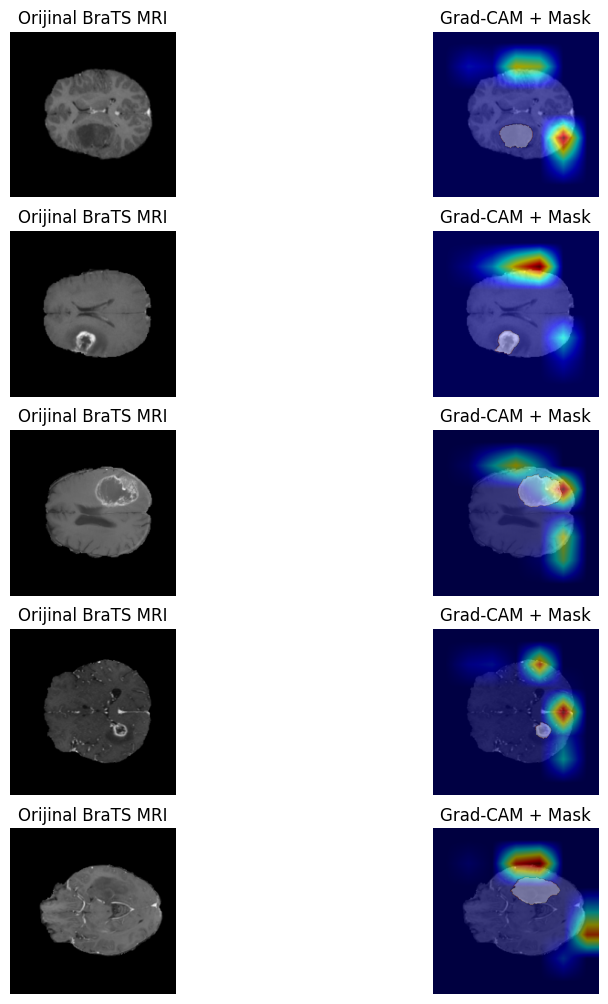

In [26]:
# Visualize Grad-CAM on random samples from BraTS dataset
brats_dir = Path(BRATS_DATASET_PATH) / "content" / "data"
csv_path = "BraTS/BraTS_selected_slices.csv"

NUM_SAMPLES = 5

with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    brats_samples = [row[0] for row in reader]

fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(10, NUM_SAMPLES * 2.5))

for i in range(NUM_SAMPLES):
    rel_path = random.choice(brats_samples)
    img_path = os.path.join(brats_dir, rel_path)

    rgb_img, input_tensor, mask = load_brats_image_for_cam(img_path)
    targets = [ClassifierOutputTarget(1)]  # All BraTS samples have tumors
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axes[i, 0].imshow(rgb_img)
    axes[i, 0].set_title("Orijinal BraTS MRI")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(visualization)
    axes[i, 1].imshow(np.ma.masked_where(mask == 0, mask), cmap='afmhot', alpha=0.35)
    axes[i, 1].set_title("Grad-CAM + Mask")
    axes[i, 1].axis("off")

In [36]:
# Compute IoU between Grad-CAM and ground truth mask for BraTS samples
from metrics.iou import ious_from_cams, iou_localization_accuracy

ious_list = []
for i in range(len(brats_samples)):
    rel_path = brats_samples[i]
    img_path = os.path.join(brats_dir, rel_path)

    rgb_img, input_tensor, mask = load_brats_image_for_cam(img_path)
    targets = [ClassifierOutputTarget(1)]  # All BraTS samples have tumors
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Compute IoU
    ious = ious_from_cams(
        cams=grayscale_cam,  
        masks=mask,        
        top_k_percent=0.15
    )
    
    ious_list.append(ious[0])

loc_acc = iou_localization_accuracy(
    ious=np.array(ious_list),
    iou_thresholds=(0.1, 0.3, 0.5, 0.7)
)

print("IoU Localization Accuracies on BraTS Dataset:")
for thresh, acc in loc_acc.items():
    print(f"  IoU > {thresh}: {acc*100:.2f}%")
print(f"Maximum IoU: {np.max(ious_list)} among {len(ious_list)} samples.")

IoU Localization Accuracies on BraTS Dataset:
  IoU > 0.1: 17.48%
  IoU > 0.3: 0.00%
  IoU > 0.5: 0.00%
  IoU > 0.7: 0.00%
Maximum IoU: 0.2822985351085663 among 326 samples.
